<a href="https://colab.research.google.com/github/ronincodex/Student-Engagement-and-Performance-SOM/blob/main/Multiclass_Engagement_and_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary Libraries

In [5]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sn

from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from sklearn.decomposition import PCA
import pandas as pd

In [6]:
import os
print(os.getcwd())

/content


# Load the Dataset

In [7]:
# Engagement Data Set
data_engagement = "Student_Engagement_Multiclass.csv"
data_performance = "Student_Performance_Multiclass.csv"

# Performance

# Read Data

In [8]:
data_performance = pd.read_csv('/content/sample_data/Student_Performance_Multiclass.csv')
data_performance = data_performance.drop(["Student ID"],axis=1)
data_performance.head(30)

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,95,91,70,90,84,64,85,85,G
1,85,76,65,61,73,64,76,76,G
2,85,41,73,61,73,61,73,73,G
3,80,78,80,79,79,57,80,79,G
4,85,91,78,80,84,67,85,85,G
5,80,79,83,87,82,60,83,83,G
6,70,91,80,81,79,73,85,85,G
7,75,65,63,71,78,31,64,64,F
8,80,87,85,88,89,59,85,85,G
9,70,68,85,91,82,71,86,86,G


# Check For Missing Values

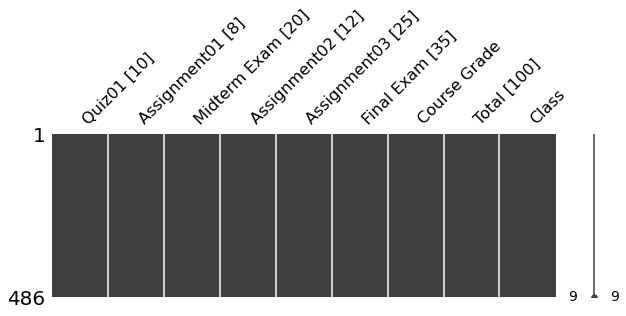

In [9]:
msno.matrix(data_performance,figsize=(10,3))


# Corelation Between Features

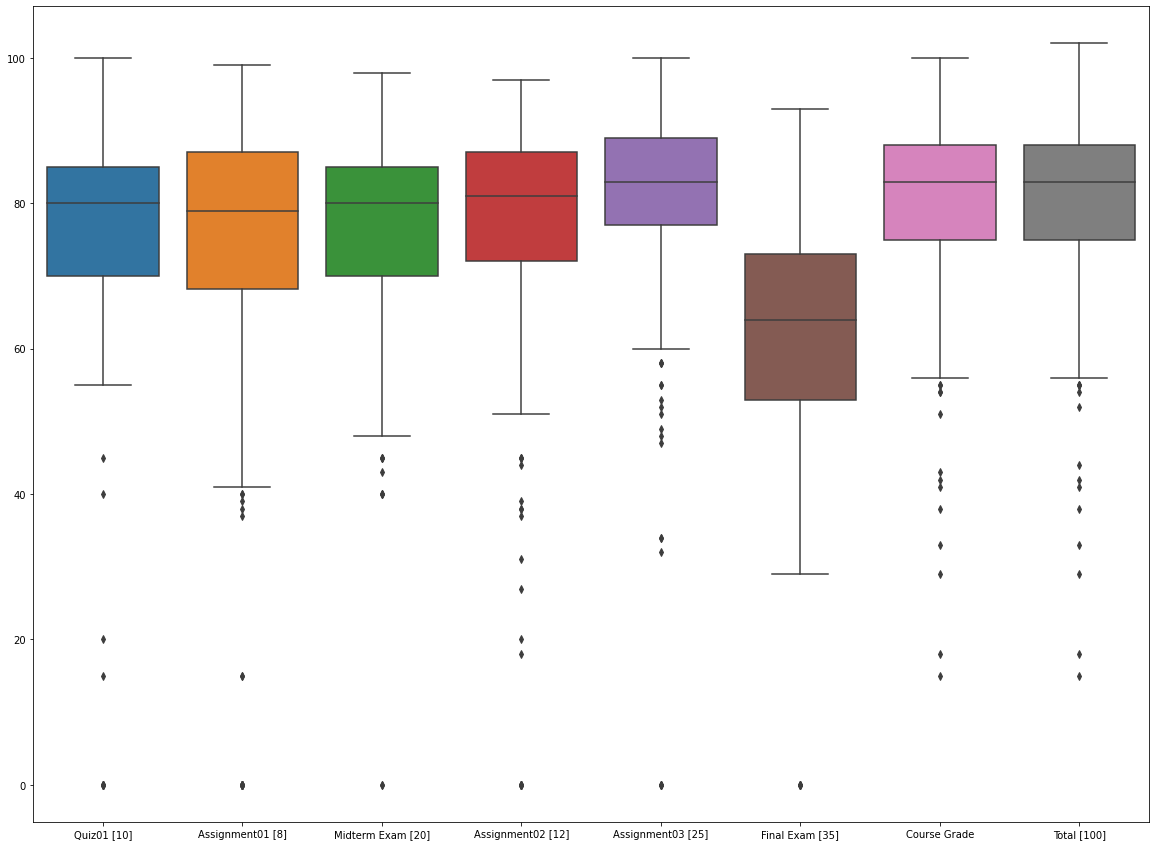

In [10]:
continiousData = data_performance.iloc[:,:-1]
continiousData.head()

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(20, 15)
sn.boxplot(data=continiousData,orient="v",ax=axes)

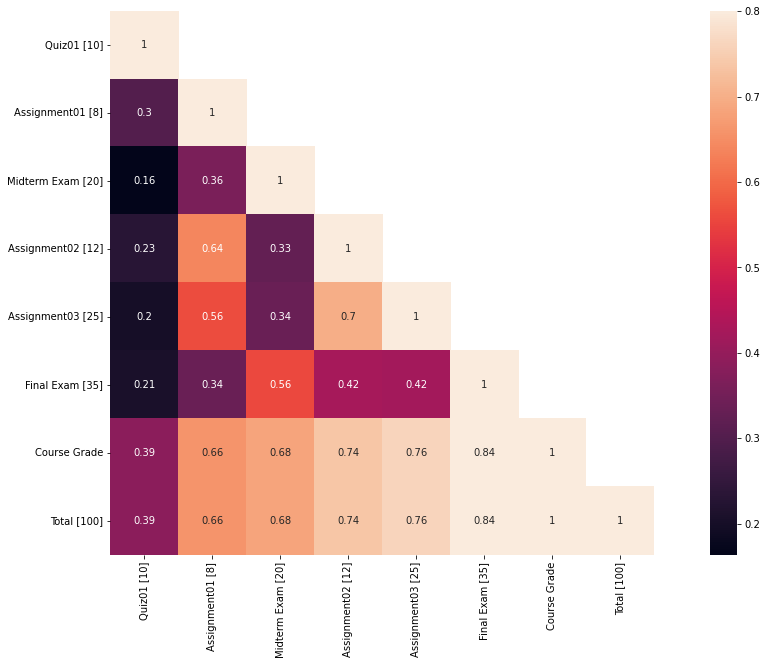

In [11]:
# Correlation analysis
corrMatt = data_performance.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

# Normalization

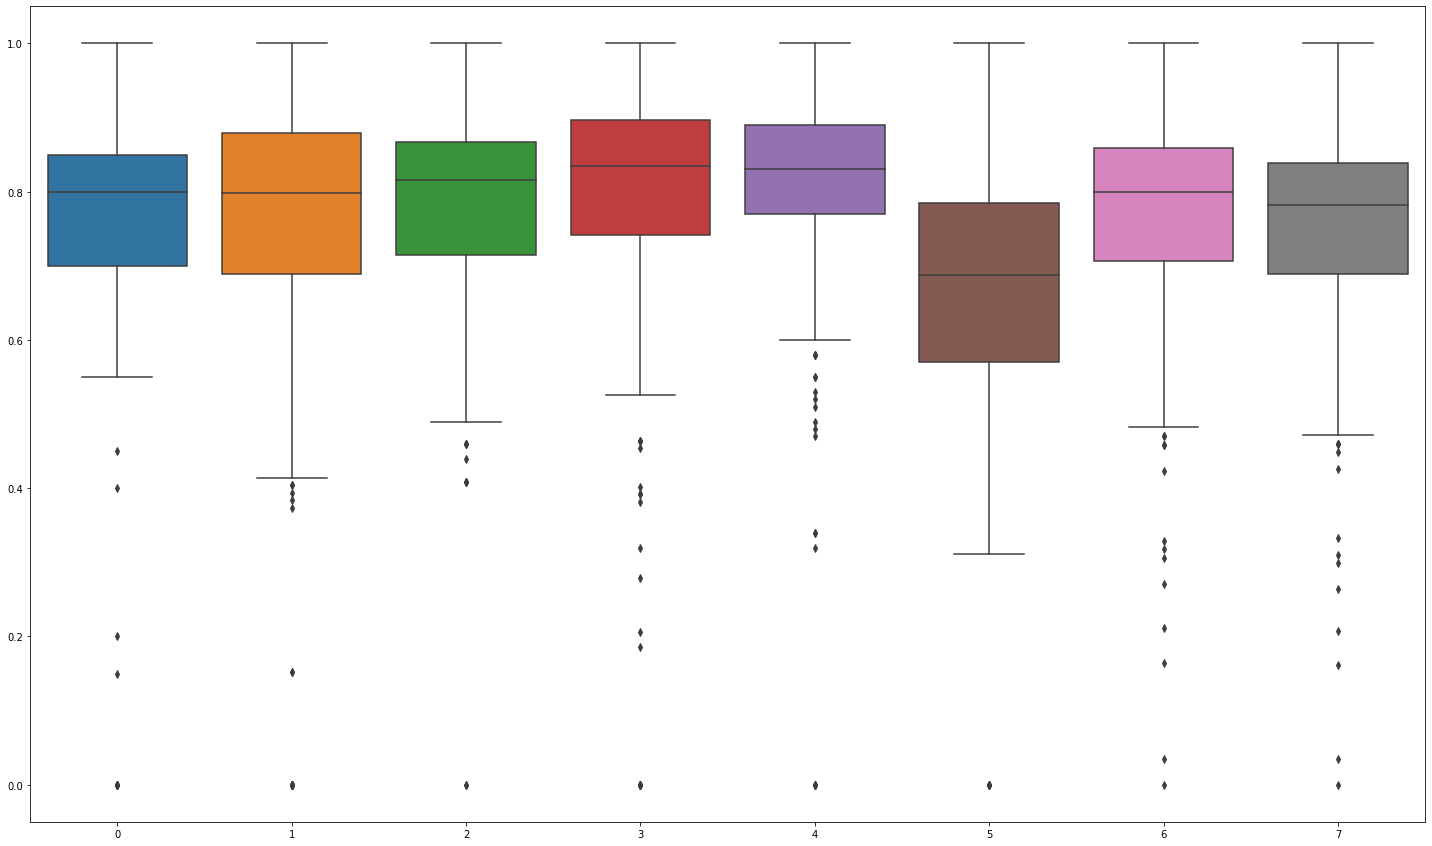

In [12]:
# normalization
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

normalized_performance=minmax_scaler(data_performance.iloc[:,:-1])
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(25, 15)
sn.boxplot(data=normalized_performance,orient="v",ax=axes)

# Unsupervised Learning Via SOM

In [13]:
## SOM

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
print(tf.__version__)

class SOM(object): 
  
  #Initialize properties
  def __init__(self, x, y, input_dim, learning_rate, radius, num_iter=500):
    self._x = x
    self._y = y
    self._learning_rate = float(learning_rate)
    self._radius = float(radius)
    self._num_iter = num_iter
    self._graph = tf.Graph()

    #Initialize graph
    with self._graph.as_default():

        #Initializing variables and placeholders
        self._weights = tf.Variable(tf.random_normal([x*y, input_dim]))
        self._locations = self._generate_index_matrix(x, y)
        self._input = tf.placeholder("float", [input_dim])
        self._iter_input = tf.placeholder("float")

        #Calculating BMU
        input_matix = tf.stack([self._input for i in range(x*y)])
        distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
        bmu = tf.argmin(distances, 0)

        #Get BMU location
        mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
        size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
        bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])

        #Calculate learning rate and radius
        decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._num_iter))
        _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
        _current_radius = tf.multiply(self._radius, decay_function)

        #Adapt learning rate to each neuron based on position
        bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
        bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
        neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
        learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)

        #Update all the weights
        multiplytiplier = tf.stack([tf.tile(tf.slice(
            learning_rate_matrix, np.array([i]), np.array([1])), [input_dim])
                                           for i in range(x*y)])
        delta = tf.multiply(
            multiplytiplier,
            tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                

        new_weights = tf.add(self._weights, delta)
        self._training = tf.assign(self._weights, new_weights)                                       

        #Initilize session and run it
        self._sess = tf.Session()
        initialization = tf.global_variables_initializer()
        self._sess.run(initialization)

  def train(self, input_vects):
      for iter_no in range(self._num_iter):
          for input_vect in input_vects:
              self._sess.run(self._training,
                            feed_dict={self._input: input_vect,
                                        self._iter_input: iter_no})

      self._centroid_matrix = [[] for i in range(self._x)]
      self._weights_list = list(self._sess.run(self._weights))
      self._locations = list(self._sess.run(self._locations))
      for i, loc in enumerate(self._locations):
          self._centroid_matrix[loc[0]].append(self._weights_list[i])

  def map_input(self, input_vectors):
      return_value = []
      for vect in input_vectors:
          min_index = min([i for i in range(len(self._weights_list))],
                          key=lambda x: np.linalg.norm(vect - self._weights_list[x]))
          return_value.append(self._locations[min_index])
      return return_value

  def _generate_index_matrix(self, x,y):
      return tf.constant(np.array(list(self._iterator(x, y))))

  def _iterator(self, x, y):
      for i in range(x):
          for j in range(y):
              yield np.array([i, j])

Instructions for updating:
non-resource variables are not supported in the long term


2.9.2


In [69]:
som = SOM(x = 3, y = 1, input_dim=8, learning_rate=0.5, num_iter = 500, radius = 1.0)
som.train(normalized_performance);

In [70]:
print(som._weights_list)
print(som._locations)
cluster_centers_df = pd.DataFrame(data=som._weights_list,columns=data_performance.iloc[:,:-3].columns)
cluster_centers_df.head()

[array([0.7999364 , 0.8341169 , 0.8448672 , 0.85672957, 0.8592624 ,
       0.75377595, 0.8476387 , 0.8292567 ], dtype=float32), array([0.7617301 , 0.6800136 , 0.69676644, 0.74244875, 0.7579428 ,
       0.5415568 , 0.66797835, 0.65372264], dtype=float32), array([0.56215745, 0.24464366, 0.6292426 , 0.20558617, 0.43130207,
       0.40916088, 0.36795565, 0.36216077], dtype=float32)]
[array([0, 0]), array([1, 0]), array([2, 0])]


,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100]
0,0.799936,0.834117,0.844867,0.856730,0.859262,0.753776,0.847639,0.829257
1,0.761730,0.680014,0.696766,0.742449,0.757943,0.541557,0.667978,0.653723
2,0.562157,0.244644,0.629243,0.205586,0.431302,0.409161,0.367956,0.362161


In [73]:
cluster_assignment = som.map_input(normalized_performance)
data_performance["cluster_som"] = cluster_assignment
data_performance["cluster"] = data_performance.apply(lambda x: "fail" if x["cluster_som"][0]==2 else 'weak' if x["cluster_som"][0]==1 else "good", axis=1)
#lambda <args> : <statement1> if <condition > ( <statement2> if <condition> else <statement3>)
data_performance = data_performance.drop(['cluster_som'],axis=1)
data_performance.head(20)

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,cluster,student id
0,95,91,70,90,84,64,85,85,G,good,student000000
1,85,76,65,61,73,64,76,76,G,weak,student000001
2,85,41,73,61,73,61,73,73,G,weak,student000002
3,80,78,80,79,79,57,80,79,G,good,student000003
4,85,91,78,80,84,67,85,85,G,good,student000004
5,80,79,83,87,82,60,83,83,G,good,student000005
6,70,91,80,81,79,73,85,85,G,good,student000006
7,75,65,63,71,78,31,64,64,F,weak,student000007
8,80,87,85,88,89,59,85,85,G,good,student000008
9,70,68,85,91,82,71,86,86,G,good,student000009


In [74]:
data_performance_raw = pd.read_csv('/content/sample_data/Student_Performance_Multiclass.csv')
data_performance['student id'] = data_performance_raw['Student ID']

data_performance.head(30)

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,cluster,student id
0,95,91,70,90,84,64,85,85,G,good,student000000
1,85,76,65,61,73,64,76,76,G,weak,student000001
2,85,41,73,61,73,61,73,73,G,weak,student000002
3,80,78,80,79,79,57,80,79,G,good,student000003
4,85,91,78,80,84,67,85,85,G,good,student000004
5,80,79,83,87,82,60,83,83,G,good,student000005
6,70,91,80,81,79,73,85,85,G,good,student000006
7,75,65,63,71,78,31,64,64,F,weak,student000007
8,80,87,85,88,89,59,85,85,G,good,student000008
9,70,68,85,91,82,71,86,86,G,good,student000009


In [75]:
data_performance.groupby("cluster").count()
#data_performance.describe()

,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class,student id
cluster,,,,,,,,,,
fail,17,17,17,17,17,17,17,17,17,17
good,305,305,305,305,305,305,305,305,305,305
weak,164,164,164,164,164,164,164,164,164,164


# Visualize Cluster

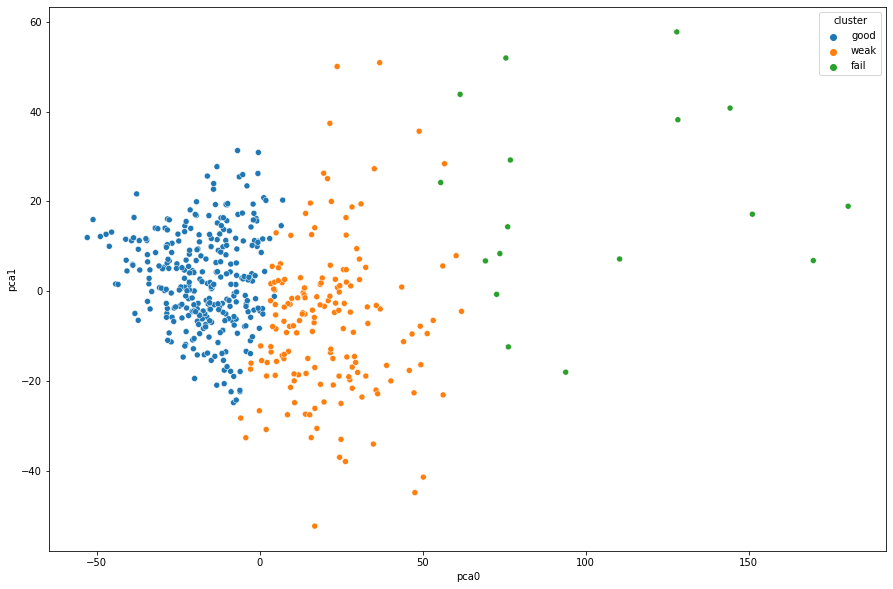

In [76]:
#pca
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
pca_performance = pd.DataFrame(pca.fit_transform(data_performance.iloc[:,:-3]))
pca_performance["cluster"] = data_performance["cluster"]
pca_performance.columns = ['pca0', 'pca1', 'cluster']
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 10))
# drawing the plot
sn.scatterplot(data=pca_performance, x='pca0', y='pca1', hue="cluster")
plt.show()

#Engagement Multiclass

In [77]:
data_engagement = pd.read_csv('/content/sample_data/Student_Engagement_Multiclass.csv')
data_engagement = data_engagement.drop(["Student ID"],axis=1)
data_engagement.head()

,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level
0,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,H
1,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,M
2,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,M
3,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,M
4,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,M


#Check For Missing Values Multiclass

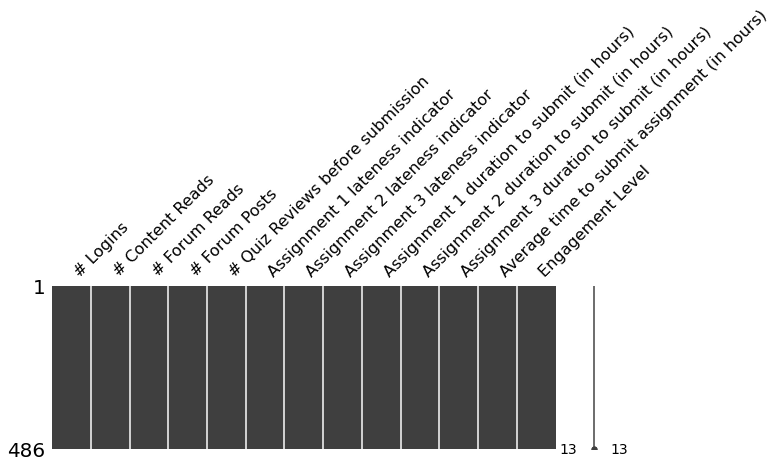

In [78]:
msno.matrix(data_engagement,figsize=(10,3))

# Multiclass Co-relation between Features

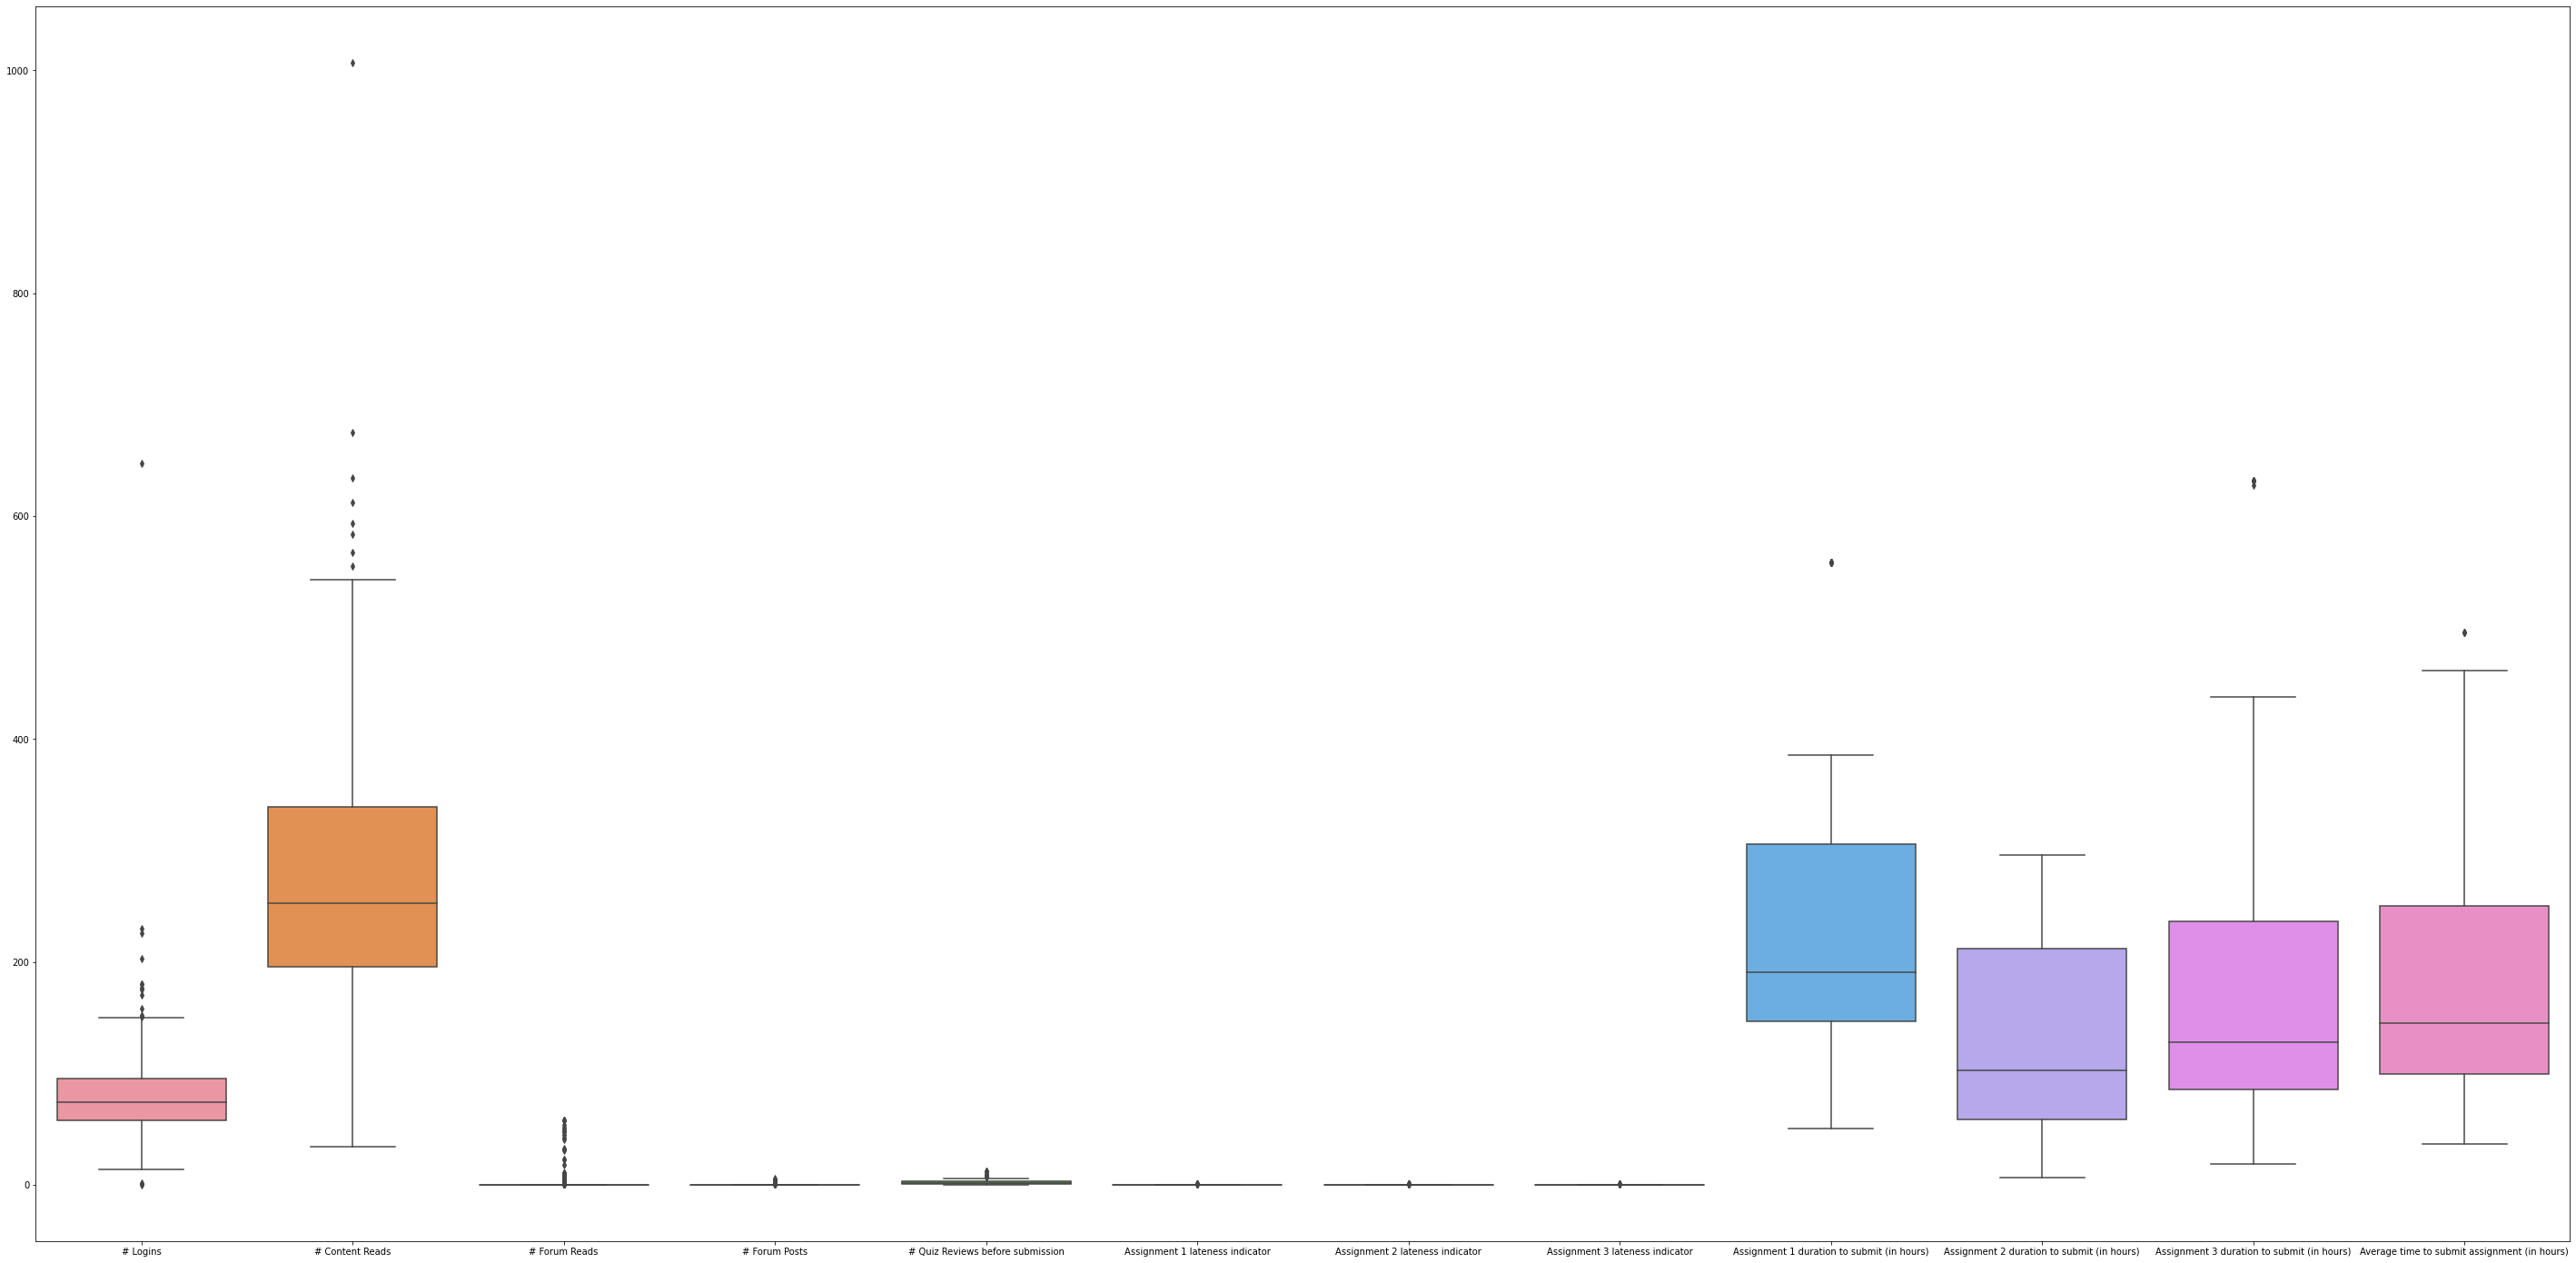

In [79]:
continiousData = data_engagement.iloc[:,:-1]
continiousData.head()

fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(50, 25)
sn.boxplot(data=continiousData,orient="v",ax=axes)

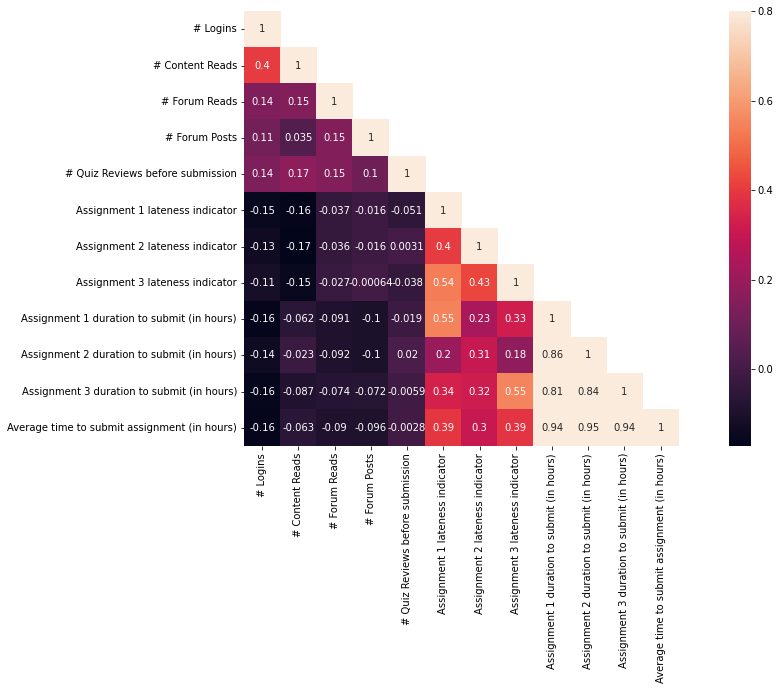

In [80]:
# Correlation analysis
corrMatt = data_engagement.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(18,8)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

# Normalization Multiclass

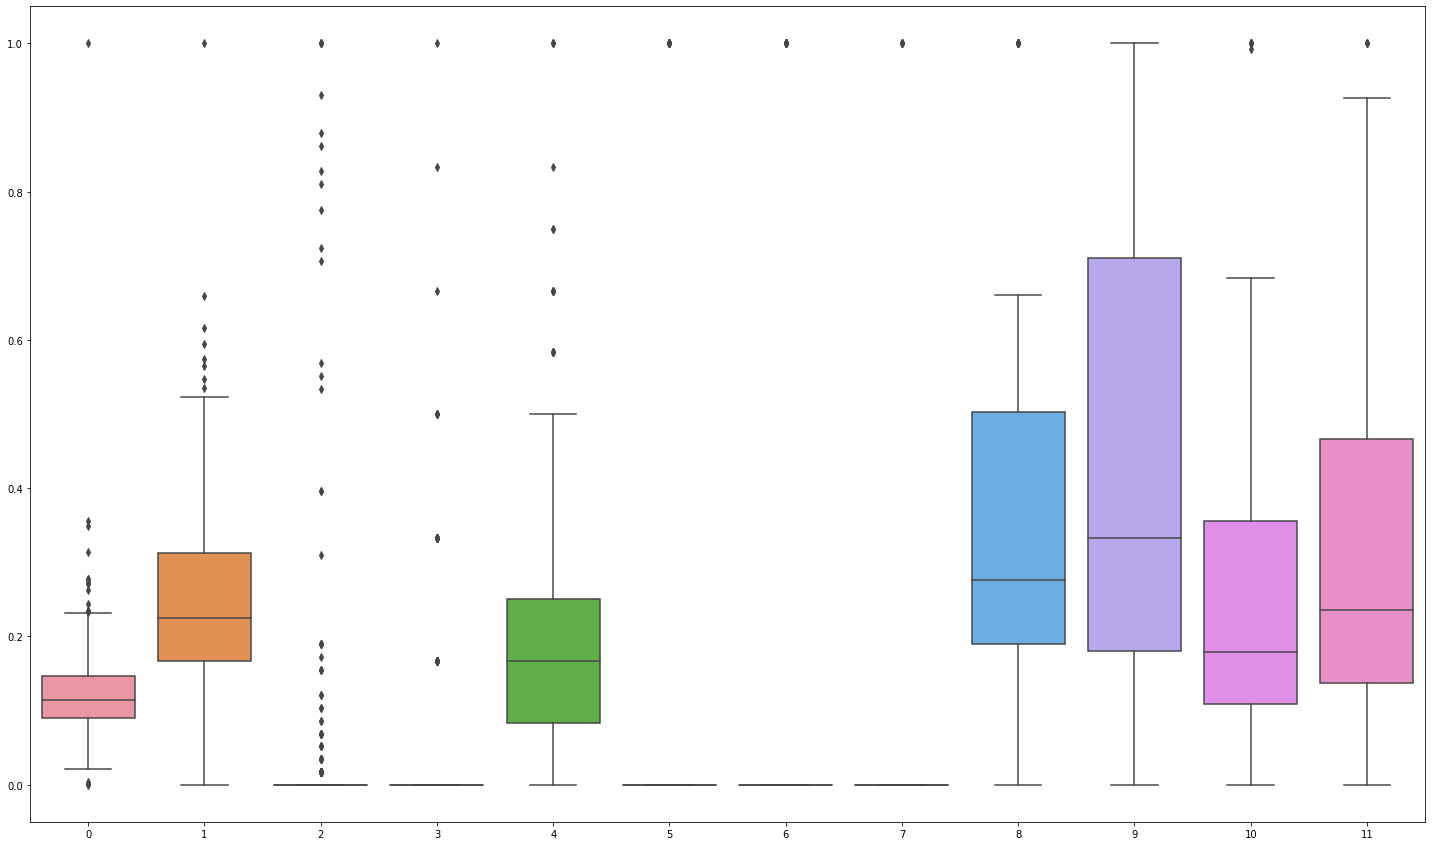

In [81]:
# normalization
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

normalized_engagement=minmax_scaler(data_engagement.iloc[:,:-1])
fig, axes = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(25, 15)
sn.boxplot(data=normalized_engagement,orient="v",ax=axes)

Unsupervised Learning Via SOM Multiclass

In [84]:
som = SOM(x = 3, y = 1, input_dim=12, learning_rate=0.5, num_iter = 200, radius = 1.0)
som.train(normalized_engagement);

In [85]:
# print(som._weights_list)
print(som._locations)
cluster_centers_df1 = pd.DataFrame(data=som._weights_list,columns=data_engagement.iloc[:,:-1].columns)
cluster_centers_df1.head()

[array([0, 0]), array([1, 0]), array([2, 0])]


,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours)
0,0.131188,0.246375,0.053673,0.032120,0.164676,1.052665e-37,2.116149e-37,2.071624e-37,0.198147,0.197813,0.121147,0.144496
1,0.122252,0.250599,0.020002,0.010018,0.175492,2.099283e-37,3.206536e-02,1.020565e-02,0.494453,0.730950,0.374821,0.478894
2,0.062522,0.133826,0.001345,0.013003,0.119915,9.999998e-01,4.113010e-01,4.033361e-01,1.000000,0.801867,0.585185,0.773701


In [106]:
cluster_assignment1 = som.map_input(normalized_engagement)
data_engagement["cluster_som"] = cluster_assignment1
data_engagement["cluster"] = data_engagement.apply(lambda x: "high" if x["cluster_som"][0]==0 else "medium" if x["cluster_som"][0]==1 else "low",axis=1)
data_engagement = data_engagement.drop(['cluster_som'],axis=1)
data_engagement.head(100)

,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level,cluster,student id
0,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,H,high,student000000
1,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,M,medium,student000001
2,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,M,medium,student000002
3,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,M,medium,student000003
4,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,M,medium,student000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,28,142,0,0,2,0,0,0,133.316667,43.883333,74.200000,83.800000,H,high,student000095
96,70,222,0,0,0,0,0,0,313.066667,223.633333,246.816667,261.172222,M,medium,student000096
97,99,507,0,0,5,0,0,0,305.666667,198.100000,220.466667,241.411111,M,medium,student000097
98,62,190,0,0,1,0,0,0,304.733333,187.433333,210.300000,234.155556,M,medium,student000098


In [107]:
data_engagement_raw = pd.read_csv('/content/sample_data/Student_Engagement_Multiclass.csv')
data_engagement['student id'] = data_engagement_raw['Student ID']

data_engagement.head()

,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level,cluster,student id
0,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,H,high,student000000
1,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,M,medium,student000001
2,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,M,medium,student000002
3,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,M,medium,student000003
4,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,M,medium,student000004


In [108]:
data_engagement.groupby("cluster").count()
#data_performance.describe()

,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level,student id
cluster,,,,,,,,,,,,,,
high,259,259,259,259,259,259,259,259,259,259,259,259,259,259
low,12,12,12,12,12,12,12,12,12,12,12,12,12,12
medium,215,215,215,215,215,215,215,215,215,215,215,215,215,215


# Visualize Cluster Multiclass

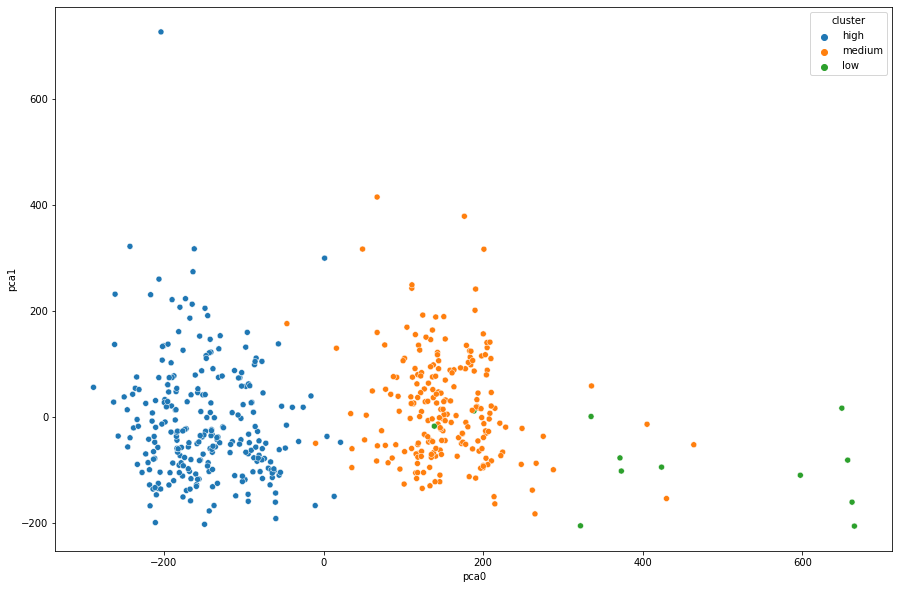

In [109]:
#pca
pca = PCA(n_components=2)
pca_engagement = pd.DataFrame(pca.fit_transform(data_engagement.iloc[:,:-3]))
pca_engagement["cluster"] = data_engagement["cluster"]
pca_engagement.columns = ['pca0', 'pca1', 'cluster']
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(15, 10))
# drawing the plot
sn.scatterplot(data=pca_engagement, x='pca0', y='pca1', hue="cluster")
plt.show()

In [110]:
# data_performance.head()
student_id_high = set(data_engagement.loc[data_engagement["cluster"]=="high"]["student id"])
student_id_medium = set(data_engagement.loc[data_engagement["cluster"]=="medium"]["student id"])
student_id_low = set(data_engagement.loc[data_engagement["cluster"]=="low"]["student id"])
print(len(student_id_high))
print(len(student_id_low))
print(len(student_id_medium))

259
12
215


In [96]:
student_id_weak = set(data_performance.loc[data_performance["cluster"]=="good"]["student id"])
student_id_fail = set(data_performance.loc[data_performance["cluster"]=="fail"]["student id"])
student_id_good = set(data_performance.loc[data_performance["cluster"]=="weak"]["student id"])
print(len(student_id_good))
print(len(student_id_weak))
print(len(student_id_fail))

164
305
17


In [97]:
good_and_high = student_id_good.intersection(student_id_high)
len(good_and_high)

77

In [100]:
good_and_medium = student_id_good.intersection(student_id_medium)
len(good_and_medium)

83

In [114]:
good_and_low = student_id_good.intersection(student_id_low)
len(good_and_low)

4

In [121]:
fail_and_high = student_id_fail.intersection(student_id_high)
len(fail_and_low)
#fail_and_high

8

In [115]:
fail_and_medium = student_id_fail.intersection(student_id_medium)
len(fail_and_medium)

5

In [116]:
fail_and_low = student_id_fail.intersection(student_id_low)
len(fail_and_low)

8

In [117]:
weak_and_high = student_id_weak.intersection(student_id_high)
len(weak_and_high)

178

In [118]:
weak_and_medium = student_id_weak.intersection(student_id_medium)
len(weak_and_medium)

127

In [119]:
weak_and_low = student_id_weak.intersection(student_id_low)
len(weak_and_low)

0